In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict

from IPython.display import HTML
from IPython.display import display_html

In [2]:
def extract_values(obj, key):
    """Recursively pull values of specified key from nested JSON."""
    arr = []

    def extract(obj, arr, key):
        """Return all matching values in an object."""
        if isinstance(obj, dict):
            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    extract(v, arr, key)
                elif k == key:
                    # if "Scan" in v:
                        # print(v)
                        # pdb.set_trace()
                    # if "Join" in v:
                        # print(obj)
                        # pdb.set_trace()
                    arr.append(v)

        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)
        return arr

    results = extract(obj, arr, key)
    return results

def column_info(row):
    expr = row["FilterExprNorm"].values[0]
    print(expr)
    d = json.loads(expr)
    col_names = extract_values(d, "name")
    col_ops = extract_values(d, "expOperator")
    num_cols = len(col_names)

* Questions
    * 'attribute': {'name': 'Confidence:3', 'dataType': 'Double'}, 'values': ['0.5D'], 'children': [], 'isSorted': True} ----> why are column names of the type col_name:%d
    * example when PartitioningColumn not in inputColumns:
        device_id v/s DeviceID
        others?
    * sometimes filter input column something like: partialRowNum0


* TODO: combine this with join tables data; Probably can't draw a lot of conclusion about partitioning etc. w/o considering the join workload

* NormInput vs HashTagInput
* inputSelected vs inputColumns
* #FilterColumns vs #FilterColumnsPerSQL. FilterColumns separate plot;
    * #FilterColumns total used for input
    * #Mean, max/min/std filter columns per job per input
* PartitioningColumn Questions:
    * PartitionColumns vs FilterColumns; How often are these the same??
    * #PartitioningColumn
    * Sanity Check: for an input, the #PartitioningColumn (std) == 0??
    * when are partitionin columns === nan / 0; how often / why? does this mean rr partitioning, or something else?
    * only one column is DESC, 550 are ASC!
* Whats up w/ the outlier inputs, e.g., one with inputColumns std peaking at 100??

* Operator questions
    * What kind of operators? distribution for each kind.
    * how often are there multiple filters on SAME column;
    * mixed operators; pairwise distributions; e.g., range + = operators are very rare
    * QUESTION: don't see ANY like operator?????
    
* VertexCount; what does this signify? how often does this change across inputs?

In [3]:
FN = "combined-0J-2021-05-22.ss.csv"
INP_FIELD = "NormInput"
#INP_FIELD = "HashTagInput"

In [4]:
df = pd.read_csv(FN, sep="|")

In [5]:
df = df.rename(columns={"#Field:JobGUID":"jobid"})

In [6]:
# For some analysis, we may not want to drop duplicates here.
#df = df.drop_duplicates(["jobid", INP_FIELD])

In [7]:
df.keys()
# check across different NormInputs ---> do distributions / selectivities remain stable across
# cases
# full schema vs not;

Index(['jobid', 'join', 'inputColumns', 'inputSelected', 'HashTag',
       'HashTagNonStrict', 'HashTagInput', 'HashTagRoot', 'OperatorName',
       'EstCardinality', 'InputCardinality', 'PartitioningColumn',
       'SortColumn', 'NormInput', 'NormInputHashCode', 'FilterExprNorm',
       'InclusiveTime', 'ExclusiveTime', 'VertexCount', 'RowCount'],
      dtype='object')

In [8]:
df["PartitioningColumn"].head(5)

0    BuildVersion:ASC,StartDateTime:ASC
1                            Sha256:ASC
2                          DeviceId:ASC
3                  ChatTranscriptId:ASC
4                  ChatTranscriptId:ASC
Name: PartitioningColumn, dtype: object

In [9]:
print(len(set(df["PartitioningColumn"])))
#print(len(df))
#print(set(df["PartitioningColumn"]))
#pcols = set(df["PartioningCol"])
for col in list(set(df["PartitioningColumn"])):
    if isinstance(col, float):
        continue
    if "ASC" not in col:
        print(col)

568
AppMoniker:DESC


In [10]:
df["inputColumns"].values[2].split("#HASH#")
# can compare this to the filtering;
# each table should be ...;
# how often are there these multi-dimensional / 2-d box queries;
# difference b/w est-card / and row-col;

['DeviceId',
 'BuildBranch',
 'FailureInfo_FailureBucketId',
 'OSOOBEDateTime',
 'FlightRing',
 'Vertical',
 'StatsGroup',
 'AttributedHits',
 'OSVersion',
 'FailureInfo_FailureHash',
 'FailureInfo_ModuleName',
 'ExperimentFolderName',
 'watsonMachineId',
 'ExpIds',
 'FirmwareVersion',
 'OSArchitecture',
 'ProcessorModel',
 'ModelHierarchyId',
 'OEMName',
 'OEMModel',
 'WPId',
 'GlobalDeviceId',
 'IsMAD']

In [11]:
expr0 = df["FilterExprNorm"].values[1]
d = json.loads(expr0)
print(d)
extract_values(d, "name")

{'isComparison': False, 'expOperator': 'Or', 'attribute': {'name': '', 'dataType': ''}, 'values': [], 'children': [{'isComparison': True, 'expOperator': '=', 'attribute': {'name': 'Confidence:3', 'dataType': 'Unknown'}, 'values': ['null'], 'children': [], 'isSorted': True}, {'isComparison': True, 'expOperator': '>=', 'attribute': {'name': 'Confidence:3', 'dataType': 'Double'}, 'values': ['0.5D'], 'children': [], 'isSorted': True}], 'isSorted': True}


['', 'Confidence:3', 'Confidence:3']

In [12]:
# Note: we are missing statistics on tables w/o Filters;
print(len(set(df["NormInput"])))
print(len(set(df["HashTagInput"])))
print(len(df))
print(len(set(df["jobid"])))
#df["VertexCount"].describe()

1697
8641
156752
90208


In [13]:
df["Selectivity"] = df.apply(lambda x: min(x["RowCount"] / x["InputCardinality"], 1.0) ,axis=1)

In [14]:
HTML(df["Selectivity"].describe(percentiles=[0.9, 0.99]).reset_index().to_html(index=False))

index,Selectivity
count,156752.000000
mean,0.193659
std,0.289819
min,0.000000
50%,0.060866
90%,0.722509
99%,1.000000
max,1.000000


# Amount of time spent in filters vs whole jobs

In [15]:
HTML(df[["ExclusiveTime", "InclusiveTime"]].describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

index,ExclusiveTime,InclusiveTime
count,1.567520e+05,1.567520e+05
mean,2.753574e+03,1.812883e+04
std,4.434537e+04,1.780507e+05
min,0.000000e+00,1.500000e-02
50%,6.465000e+00,2.506925e+02
90%,2.285131e+02,5.354030e+03
99%,2.833385e+04,3.865476e+05
max,1.546314e+06,1.391293e+07


In [51]:
df = df[df.InclusiveTime >= 2.506925e+02]

In [52]:
df2 = df.drop_duplicates("jobid")
# sns.distplot(df2["ExclusiveTime"].values)
# #plt.ylim([0,3])
# plt.xlim([0,1])
#plt.xscale("log")

In [53]:
df2["ExclusiveTime"].head(1000)

1       1496.866
3         59.744
62         7.014
64      4467.739
67       464.742
          ...   
4477    1344.021
4478      13.350
4480     268.463
4486       1.627
4491       2.022
Name: ExclusiveTime, Length: 1000, dtype: float64

In [54]:
print(len(set(df[INP_FIELD])))

776


In [55]:
print(len(set(df["jobid"])))

33196


In [56]:
# def update_df_col_stats(df):
#     cur_row = None

#     inp_to_filter_cols = defaultdict(set)
#     inp_to_ops = defaultdict(set)
#     inp_to_num_cols = defaultdict(list)

#     num_ops_all = []
#     num_filter_cols_all = []
#     num_cols_all = []
#     num_cols_sel = []
#     num_unique_ops_all = []

#     num_err = 0

#     for idx, row in df.iterrows():
#         cur_row = row
#         expr = row["FilterExprNorm"]
#         inpcols_all = row["inputColumns"]
#         inp_selected = row["inputSelected"]
#         inp = row[INP_FIELD]
#         if expr == "#NULL":
#             num_err += 1 
#             num_ops_all.append(-1)
#             #num_unique_cols_all.append(-1)
#             num_filter_cols_all.append(-1)
#             num_unique_ops_all.append(-1)
#             num_cols_all.append(-1)
#             continue
#         else:
#             d = json.loads(expr)

#         col_names = extract_values(d, "name")
#         col_ops = extract_values(d, "expOperator")

#         seen_cols = []
#         seen_ops = []
#         num_unique_cols = 0
#         num_unique_ops = 0
#         num_operators = 0


#         for j, col in enumerate(col_names):
#             if col == "":
#                 continue
#             num_operators += 1

#             inp_to_filter_cols[inp].add(col)
#             inp_to_ops[inp].add(col_ops[j])

#             if col not in seen_cols:
#                 num_unique_cols += 1
#             if col_ops[j] not in seen_ops:
#                 num_unique_ops += 1

#             seen_cols.append(col)
#             seen_ops.append(col_ops[j])

#         num_cols_all.append(inpcols_all.count("#") + 1)
#         num_cols_sel.append(inp_selected.count("#") + 1)
#         num_ops_all.append(num_operators)
#         num_filter_cols_all.append(num_unique_cols)
#         num_unique_ops_all.append(num_unique_ops)


In [57]:
cur_row = None

inp_to_filter_cols = defaultdict(set)
inp_to_pcols = defaultdict(set)
inp_to_all_cols = defaultdict(set)

inp_to_ops = defaultdict(set)
inp_to_num_cols = defaultdict(list)


num_ops_all = []
num_filter_cols_all = []
num_cols_all = []
num_cols_sel = []
num_unique_ops_all = []
num_pcols = []

num_err = 0

for idx, row in df.iterrows():
    cur_row = row
    expr = row["FilterExprNorm"]
    inpcols_all = row["inputColumns"]
    inp_sel = row["inputSelected"]
    inp = row[INP_FIELD]
    try:
        d = json.loads(expr)
    except:
        num_err += 1 
        num_ops_all.append(-1)
        #num_unique_cols_all.append(-1)
        num_filter_cols_all.append(-1)
        num_unique_ops_all.append(-1)
        num_cols_all.append(-1)
        num_cols_sel.append(-1)
        num_pcols.append(-1)
        continue
    
    allcollist = inpcols_all.split("#HASH#")
    for col in allcollist:
        inp_to_all_cols[inp].add(col)
    
    pcols = row["PartitioningColumn"]
    if isinstance(pcols, float):
        curpcols = 0
    else:
        pcols = pcols.split(",")
        curpcols = 0
        for pcol in pcols:
            pcol = pcol.replace(":ASC", "")
            pcol = pcol.replace(":DESC", "")
            inp_to_pcols[inp].add(pcol)
            curpcols += 1
    
    col_names = extract_values(d, "name")
    col_ops = extract_values(d, "expOperator")
    
    #num_cols = len(set(col_names))
    #print(num_cols)
    seen_cols = []
    seen_ops = []
    num_unique_cols = 0
    num_unique_ops = 0
    num_operators = 0
    
    for j, col in enumerate(col_names):
        if col == "":
            continue
        num_operators += 1
        
        parsedcol = col[0:col.find(":")]
        inp_to_filter_cols[inp].add(parsedcol)
        inp_to_ops[inp].add(col_ops[j])
        
        if col not in seen_cols:
            num_unique_cols += 1
        if col_ops[j] not in seen_ops:
            num_unique_ops += 1
    
        seen_cols.append(col)
        seen_ops.append(col_ops[j])

    #inp_to_num_cols[col].append(inpcols_all.count("#"))
    num_cols_all.append(inpcols_all.count("#") + 1)
    num_cols_sel.append(inp_sel.count("#")+1)
    
    num_ops_all.append(num_operators)
    num_filter_cols_all.append(num_unique_cols)
    num_unique_ops_all.append(num_unique_ops)
    num_pcols.append(curpcols)
    
print("final num decode errors: ", num_err)


final num decode errors:  0


In [58]:
num_common_partitions = 0
for inp, cols in inp_to_filter_cols.items():
    for col in cols:
        if col not in inp_to_all_cols[inp]:
            continue

        if col in inp_to_pcols[inp]:
            num_common_partitions += 1
            print(inp)
            print(inp_to_all_cols[inp])
            print("Filter cols: ", col)
            print("Partition: ", inp_to_pcols[inp])
        
            break
        
        #assert col in inp_to_all_cols[inp]
        
#     for pcol in inp_to_pcols[inp]:
#         assert pcol in inp_to_all_cols[inp]
    
#     print(inp_to_all_cols[inp])
#     print(cols)
#     print(inp_to_pcols[inp])
    
    print("*******************")

*******************
*******************
adl://mdollar-prod-cX.azuredatalakestore.net/local/PSI/ProductContainer/PROD/Games/vX/Input/[Date]-X-X/ContainerDocuments.ss
{'ProductContainerDocument', 'ProductId'}
Filter cols:  ProductId
Partition:  {'ProductId'}
*******************
*******************
*******************
*******************
adl://asimov-prod-data-cX.azuredatalakestore.net/local/Public/InsightsReports/ActiveDeviceMetrics/vX/Prod/Processed/MAD/WinX/X/X/ADM_DeviceLevel_X_X_X.ss
{'IsCurrentlyInInternalBranch', 'WeightedCalendarMonthTH2', 'IsWhiteBoxNewWin10Device', 'FirstSeenRS1EventIngestTime', 'WeightedRolling7RS2', 'ActiveBitmapWindow', 'LateArrivingIsShortLivedVM', 'DeviceAge', 'DeviceAgeDateTime', 'MSSalesSubSegment', 'OSType', 'DeviceMake', 'WeightedRolling28RS4', 'AdjustedWeightedRolling28RS3', 'FormFactor', 'FirstEverSeenEventIngestTime', 'FirstSeenRS4EventIngestTime', 'AgeGroup', 'DeviceTypeCategory', 'ProcessorModel', 'IsNewWindows10Device', 'DeviceModelId', 'EndDate',

In [59]:
print(num_common_partitions)

116


In [60]:
df["num_ops"] = num_ops_all
df["num_unique_ops"] = num_unique_ops_all
df["unique_filter_cols"] = num_filter_cols_all 
df["num_cols_all"] = num_cols_all
df["num_cols_sel"] = num_cols_sel
df["num_pcols"] = num_pcols

In [61]:
df = df[df["num_ops"] != -1]

In [62]:
HTML(df[["num_ops", "num_unique_ops", "num_cols_all", "unique_filter_cols", "num_pcols"]].\
     describe(percentiles=[0.9,0.99]).reset_index().to_html(index=False))

index,num_ops,num_unique_ops,num_cols_all,unique_filter_cols,num_pcols
count,76047.000000,76047.000000,76047.000000,76047.000000,76047.000000
mean,1.369180,1.006509,81.782569,1.057478,1.195945
std,2.427553,0.540350,154.540423,0.705531,0.988036
min,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,37.000000,1.000000,1.000000
90%,2.000000,1.000000,159.000000,1.000000,2.000000
99%,7.000000,3.000000,829.000000,4.000000,4.000000
max,50.000000,5.000000,8197.000000,18.000000,17.000000


# Up to 90th percentile, inputs have exact same columns being used

In [63]:
df.groupby(INP_FIELD)["num_cols_all"].std().reset_index().describe(percentiles=[0.9,0.99])

,num_cols_all
count,623.000000
mean,13.928001
std,233.066884
min,0.000000
50%,0.000000
90%,2.373374
99%,135.425354
max,5786.961897


In [64]:
df.groupby(INP_FIELD)["num_cols_sel"].std().reset_index().describe(percentiles=[0.9,0.99])

,num_cols_sel
count,623.000000
mean,0.934839
std,3.326445
min,0.000000
50%,0.000000
90%,2.766064
99%,12.679743
max,39.933278


In [65]:
df.groupby(INP_FIELD)["num_cols_all"].mean().reset_index().describe(percentiles=[0.9,0.99])

,num_cols_all
count,776.000000
mean,111.019989
std,221.163550
min,3.000000
50%,45.000000
90%,244.000000
99%,834.000000
max,4105.000000


In [66]:
# df.groupby(INP_FIELD)["unique_filter_cols"].std().reset_index().describe(\
#     percentiles=[0.9,0.99])
df.groupby(INP_FIELD)["unique_filter_cols"].max().reset_index().describe(\
    percentiles=[0.9,0.99])

,unique_filter_cols
count,776.000000
mean,1.134021
std,1.312993
min,0.000000
50%,1.000000
90%,3.000000
99%,6.000000
max,18.000000


In [67]:
# df.groupby(INP_FIELD)["unique_filter_cols"].std().reset_index().describe(\
#     percentiles=[0.9,0.99])
df.groupby(INP_FIELD)["num_pcols"].mean().reset_index().describe(\
    percentiles=[0.25, 0.9,0.99])

,num_pcols
count,776.000000
mean,1.549067
std,1.508337
min,0.000000
25%,1.000000
50%,1.000000
90%,3.000000
99%,6.250000
max,17.000000


In [68]:
job_counts = df.groupby(INP_FIELD)["jobid"].count().reset_index()
job_stds = df.groupby(INP_FIELD)["Selectivity"].std().reset_index()
job_cards = df.groupby(INP_FIELD)["RowCount"].std().reset_index()
job_col_stds = df.groupby(INP_FIELD)["num_cols_all"].std().reset_index()
job_colsel_stds = df.groupby(INP_FIELD)["num_cols_sel"].std().reset_index()
job_tmps = df.groupby(INP_FIELD)["HashTagNonStrict"].nunique().reset_index()
job_filtercols = df.groupby(INP_FIELD)["unique_filter_cols"].max().reset_index()
job_pcols = df.groupby(INP_FIELD)["num_pcols"].mean().reset_index()

#print(job_tmps.keys())

#num_cols = df.groupby(INP_FIELD)["RowCount"].std().reset_index()

inp_stats = job_counts.merge(job_stds, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_cards, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_col_stds, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_colsel_stds, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_filtercols, on=INP_FIELD, how="inner")
inp_stats = inp_stats.merge(job_tmps, on=INP_FIELD,how="inner")
inp_stats = inp_stats.merge(job_pcols, on=INP_FIELD, how="inner")

inp_stats = inp_stats.rename(columns={"Selectivity":"Selectivity (std)", "jobid": "#Jobs", 
                                     "RowCount": "Cardinality (std)",
                                     "num_cols_all": "#InpColumns (std)",
                                     "num_cols_sel": "#SelColumns (std)",
                                     "unique_filter_cols": "#FilterColumns",
                                     "HashTagNonStrict": "#Templates",
                                     "num_pcols":"#PartitionColumns"
                                     })
#print(inp_stats.keys())
inp_stats = inp_stats[inp_stats["#Jobs"] > 10]

inp_stats = inp_stats.convert_dtypes()
#inp_stats["NumUniqueCols"] = inp_stats.apply(lambda x: len(inp_to_cols[x[INP_FIELD]]), axis=1)

#inp_stats["NumUniqueOps"] = inp_stats.apply(lambda x: len(inp_to_ops[x[INP_FIELD].values[0]]), axis=1)
num_unique_filter_cols = []
num_unique_ops = []

num_partition_filter_same = []
num_filter_in_partition = []

for idx, row in inp_stats.iterrows():
    inp = row[INP_FIELD]
    filtercols = inp_to_filter_cols[inp]
    part_cols = inp_to_pcols[inp]
    
    num_unique_filter_cols.append(len(filtercols))
    
    allsame = True
    onesame = False
    if len(filtercols) == 0:
        allsame = False
        onesame = False
    
    for fcol in filtercols:
        if fcol in part_cols:
            onesame = True
        else:
            allsame = False
            
    if allsame:
        #num_partition_filter_same.append(1)
        num_filter_in_partition.append(2)
    else:
        if onesame:
            num_filter_in_partition.append(1)
        else:
            num_filter_in_partition.append(0)

        #num_partition_filter_same.append(0)
        
#     if onesame:
#         num_filter_in_partition.append(1)
#     else:
#         num_filter_in_partition.append(0)
    
inp_stats["AllFilterColumns"] = num_unique_filter_cols
inp_stats["FilterInPartition"] = num_filter_in_partition
#inp_stats["SamePartitionFilter"] = num_partition_filter_same

In [69]:
print(len(inp_stats))

353


In [70]:
inp_stats.keys()

Index(['NormInput', '#Jobs', 'Selectivity (std)', 'Cardinality (std)',
       '#InpColumns (std)', '#SelColumns (std)', '#FilterColumns',
       '#Templates', '#PartitionColumns', 'AllFilterColumns',
       'FilterInPartition'],
      dtype='object')

In [71]:
inp_stats['FilterInPartition'].describe(percentiles=[0.75, 0.9, 0.99]).reset_index()

,index,FilterInPartition
0,count,353.000000
1,mean,0.263456
2,std,0.618141
3,min,0.000000
4,50%,0.000000
5,75%,0.000000
6,90%,1.000000
7,99%,2.000000
8,max,2.000000


In [72]:
#inp_stats['SamePartitionFilter'].describe(percentiles=[0.75, 0.9, 0.99]).reset_index()

In [73]:
inp_stats['#InpColumns (std)'].describe(percentiles=[0.9, 0.99]).reset_index()

,index,#InpColumns (std)
0,count,353.000000
1,mean,4.577082
2,std,22.133846
3,min,0.000000
4,50%,0.000000
5,90%,2.006954
6,99%,125.888825
7,max,222.194828


In [74]:
# inp_stats = inp_stats.sort_values(by="#Jobs", ascending=False)
# inp_stats.head(40)

In [75]:
# inp_stats = inp_stats.sort_values(by="Selectivity (std)", ascending=False)
# inp_stats.head(50)

In [76]:
# inp_stats = inp_stats.sort_values(by="AllFilterColumns", ascending=False)
# inp_stats.head(50)

In [77]:
inp_stats.keys()

Index(['NormInput', '#Jobs', 'Selectivity (std)', 'Cardinality (std)',
       '#InpColumns (std)', '#SelColumns (std)', '#FilterColumns',
       '#Templates', '#PartitionColumns', 'AllFilterColumns',
       'FilterInPartition'],
      dtype='object')

In [78]:
inp_stats = inp_stats.sort_values(by="#Jobs", ascending=False).reset_index(drop=True)

In [79]:
order = inp_stats[INP_FIELD].values

In [80]:
#inp2 = inp_stats.sample(10)
#order = inp2[INP_FIELD].values

In [81]:
#FIELDS = ["#Jobs", "#Templates", "Cardinality (std)", "#InpColumns (std)",
#         "AllFilterColumns"]

LOGFIELDS = ["#Jobs", "#Templates"]
FIELDS = ["#Jobs", "#Templates", "AllFilterColumns", "#FilterColumns",
          "#PartitionColumns",
          "FilterInPartition",
          "#InpColumns (std)", 
          "#SelColumns (std)",
          "Selectivity (std)"]

FIELDS2 = ["#Jobs", "#Templates", "AllFilterColumns", "#FilterColumns",
          "#PartitionColumns",
          "FilterInPartition"]

FIELDS3 = ["#Jobs", "#Templates",
           "#FilterColumns",
          "#InpColumns (std)", 
          "#SelColumns (std)",
          "Selectivity (std)"]

#YSCALES = [True, True, False, False, False, False, False, False, False]

In [82]:
# ysize = 6*len(FIELDS)
# fig, axs = plt.subplots(nrows=len(FIELDS),ncols=1,figsize=(20,ysize))

# for i, fld in enumerate(FIELDS):
#     #sns.barplot(data=inp_stats, x = INP_FIELD, y = "#Jobs", color="k", order=order, ax=axs[i])
#     sns.barplot(data=inp_stats, x = INP_FIELD, y = fld, color="k", order=order, ax=axs[i])
#     axs[i].set_yscale("log")
#     axs[i].xaxis.set_visible(False)
    #plt.show()

In [83]:
#inp_stats["NumJobs"] = inp_stats.apply(lambda x: x["#Jobs"],axis=1)
print(np.sum(inp_stats["#Jobs"]))

74777


In [84]:
def plot_input_stats(inp_stats, allfields, fn):
    inp_stats2 = inp_stats[inp_stats["#Templates"] > 10]
    print(len(inp_stats2))
    print(np.sum(inp_stats2["#Jobs"]))

    order2 = inp_stats2[INP_FIELD].values
    ysize = 4*len(allfields)
    fig, axs = plt.subplots(nrows=len(allfields),ncols=1,figsize=(15,ysize))
    plt.subplots_adjust(wspace=0.0, 
                        hspace=0.01)

    for i, fld in enumerate(allfields):
        sns.barplot(data=inp_stats2, x = INP_FIELD, y = fld, color="b", order=order2, ax=axs[i])
        if fld in LOGFIELDS:
            axs[i].set_yscale("log")
        axs[i].xaxis.set_visible(False)
        axs[i].set_ylabel(fld, fontsize=20)
        #axs[i].set_yticklabels
        axs[i].tick_params(axis='both', which='major', labelsize=20)
        if i == len(allfields)-1:
            #print("xlabel!")
            #plt.xlabel(INP_FIELD, fontsize=16)
            axs[i].set_xlabel(INP_FIELD, fontsize=20)

    plt.savefig(fn, bbox_inches="tight")

107
17572


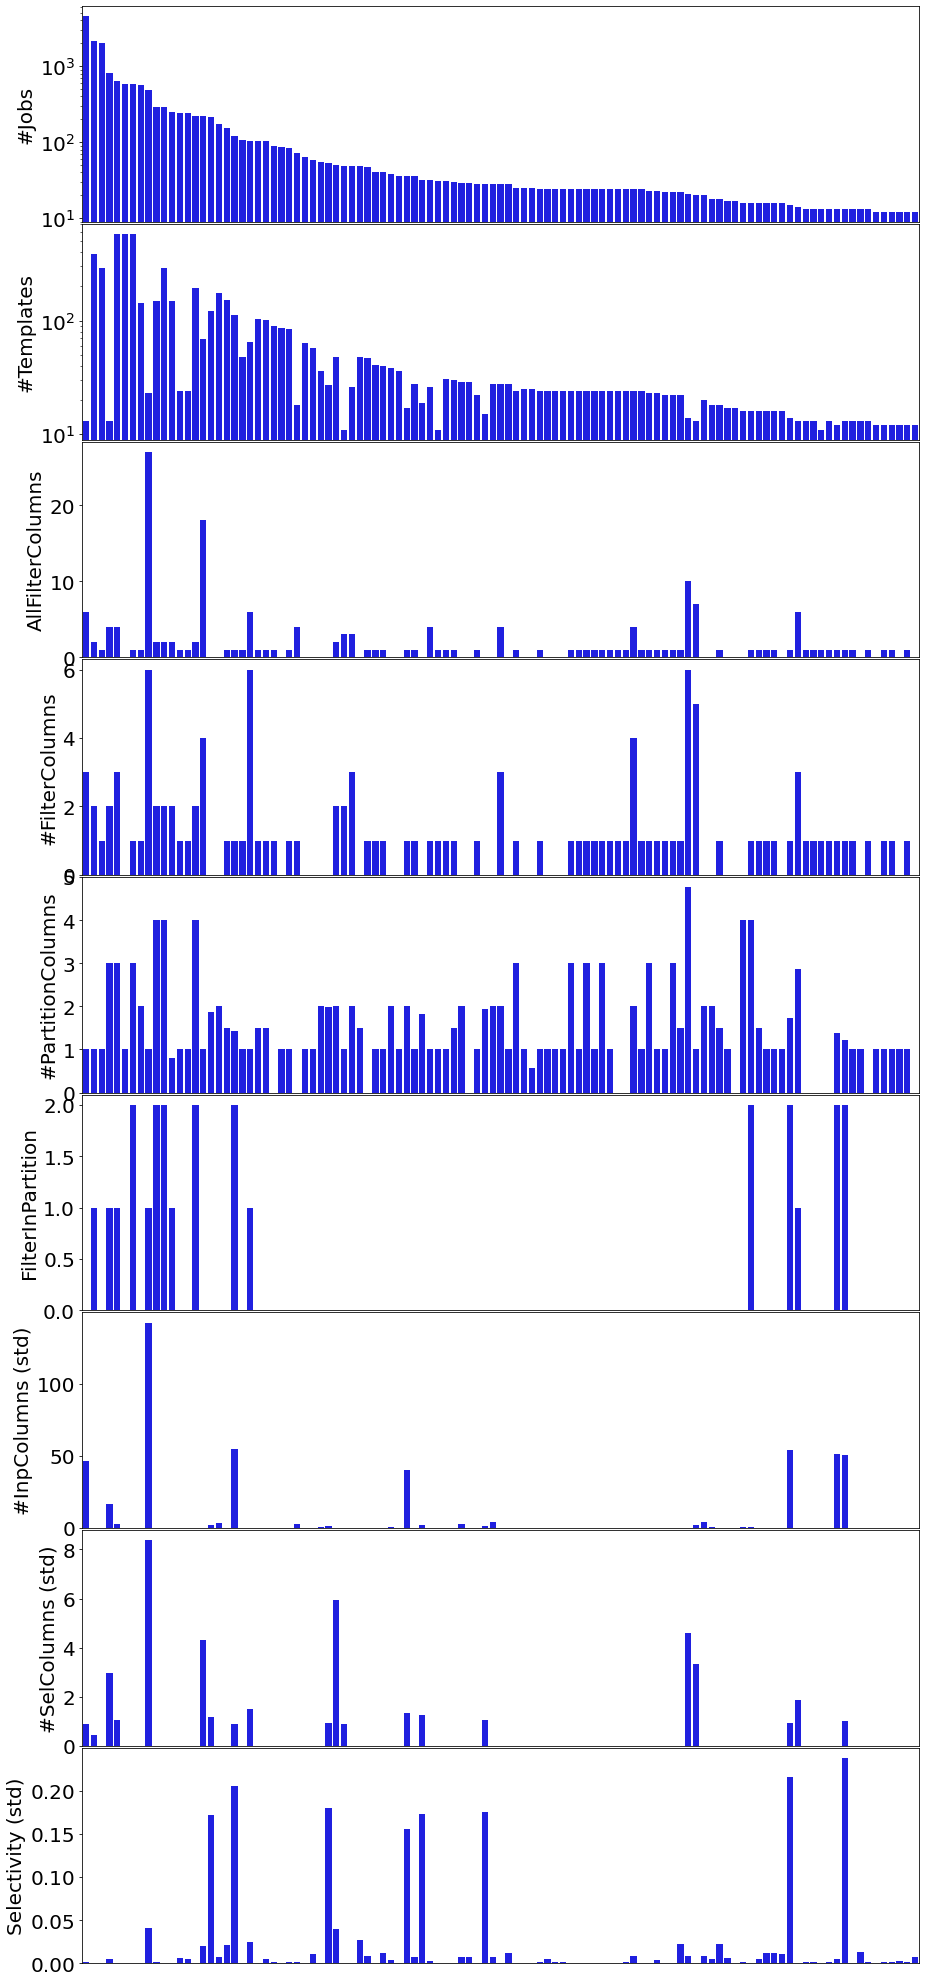

In [85]:
plot_input_stats(inp_stats, FIELDS, "/Users/pari/Desktop/InputStats-DiffTemplates.pdf")

173
27538


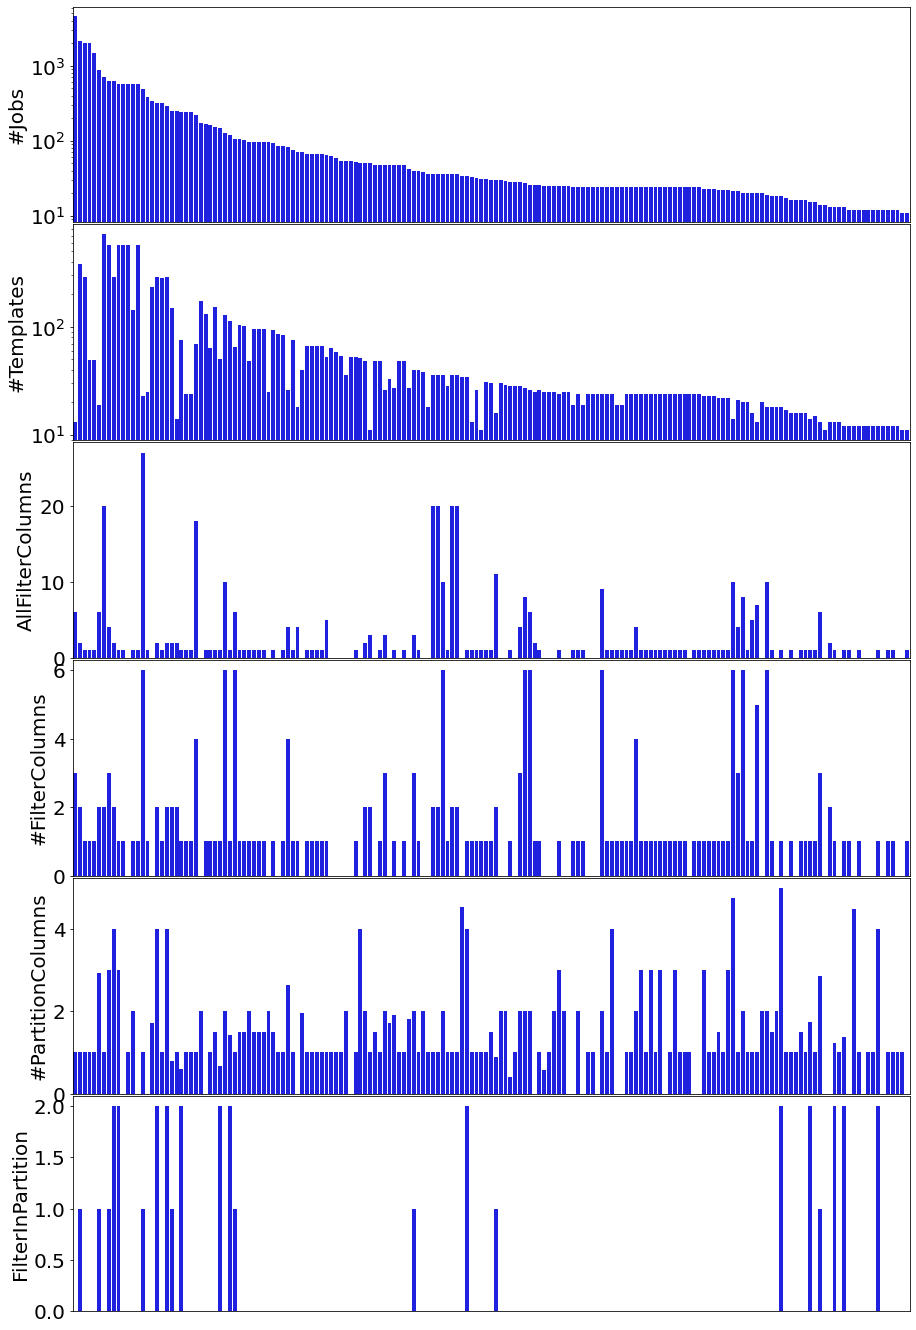

In [50]:
plot_input_stats(inp_stats, FIELDS2, "/Users/pari/Desktop/InputStats2-DiffTemplates.pdf")

173
27538


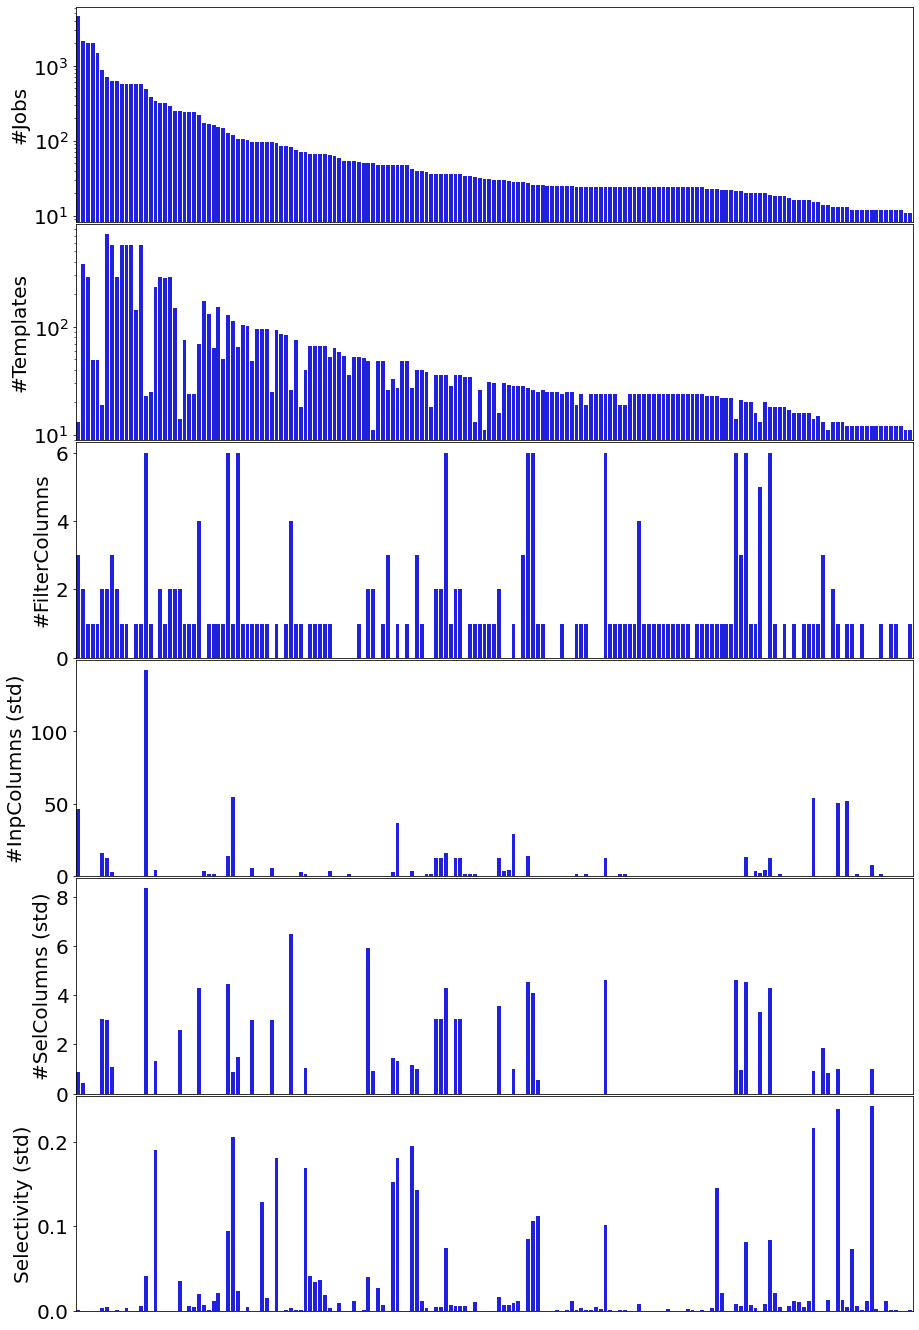

In [51]:
plot_input_stats(inp_stats, FIELDS3, "/Users/pari/Desktop/InputStats3-DiffTemplates.pdf")

In [474]:
inp_stats["#Templates"].describe()

count    788.000000
mean      15.893401
std       61.302000
min        1.000000
25%        1.000000
50%        1.000000
75%        6.000000
max      720.000000
Name: #Templates, dtype: float64

In [475]:
inp_stats.keys()

Index(['NormInput', '#Jobs', 'Selectivity (std)', 'Cardinality (std)',
       '#InputColumns', '#ColumnsSelected', '#Templates', '#Filter Columns'],
      dtype='object')

# Most filters of the kind

In [476]:
tmp_df = df[df.HashTagInput == 11700902958082612250]
print(tmp_df["FilterExprNorm"].values[0])

{"isComparison":true,"expOperator":"String.IsNullOrEmpty(Duration)","attribute":{"name":"","dataType":""},"values":[],"children":[],"isSorted":true}


In [62]:
tmp_df = df[df.HashTagInput == 3929217785330710594]
print(tmp_df["FilterExprNorm"].values[1])

{"isComparison":false,"expOperator":"Or","attribute":{"name":"","dataType":""},"values":[],"children":[{"isComparison":true,"expOperator":"!=","attribute":{"name":"Category:3","dataType":"String"},"values":["\"Browser\""],"children":[],"isSorted":true},{"isComparison":true,"expOperator":"=","attribute":{"name":"AppName:2","dataType":"String"},"values":["\"Total Excludes Browser All\""],"children":[],"isSorted":true}],"isSorted":true}


In [64]:
test_attr = tmp_df["FilterExprNorm"].values[1]
d = json.loads(test_attr)
col_names = extract_values(d, "name")
col_names

['', 'Category:3', 'AppName:2']

In [65]:
test_attr

'{"isComparison":false,"expOperator":"Or","attribute":{"name":"","dataType":""},"values":[],"children":[{"isComparison":true,"expOperator":"!=","attribute":{"name":"Category:3","dataType":"String"},"values":["\\"Browser\\""],"children":[],"isSorted":true},{"isComparison":true,"expOperator":"=","attribute":{"name":"AppName:2","dataType":"String"},"values":["\\"Total Excludes Browser All\\""],"children":[],"isSorted":true}],"isSorted":true}'

In [316]:
len(inp_to_cols[3929217785330710594])

3

In [317]:
test = inp_stats[inp_stats["HashTagInput"] == 3929217785330710594]
test

,HashTagInput,Number of Jobs,Selectivity (Standard Deviation),Cardinality (Standard Deviation),NumUniqueCols
1754,3929217785330710594,10,0.482537,489.229053,0


In [318]:
inp_to_cols[test["HashTagInput"].values[0]]

{'AppName:2', 'Category:3', 'ScaledEngagementMinsDisplay:9'}

In [319]:
type(test["HashTagInput"].values[0])
#test = test.convert_dtypes()

numpy.uint64

In [321]:
for idx,row in test.iterrows():
    print(type(row["HashTagInput"]))
    print(int(row["HashTagInput"]))
    print(row["HashTagInput"])

<class 'int'>
3929217785330710594
3929217785330710594


# Exploring columns per input

In [67]:
df.groupby(["HashTagInput", "inputColumns"]).describe()

join  \
                                                                        count   
HashTagInput         inputColumns                                               
1698460498013176     Label#HASH#Sha256#HASH#LsHash#HASH#Source#HASH#...   1.0   
2333787895897435     TotalTelSrE5#HASH#TotalTelSr#HASH#NeoHash#HASH#...   2.0   
2527632998264901     device_id#HASH#os_bootId#HASH#buildNum#HASH#osV...   2.0   
4068920478340253     Label#HASH#Sha256#HASH#Ctph#HASH#PeAttributesSt...   1.0   
                     Label#HASH#Sha256#HASH#Weight#HASH#Ctph#HASH#Pe...   1.0   
...                                                                       ...   
18433117768287249911 TestDate#HASH#IsUnderserved#HASH#Tester#HASH#Te...   1.0   
18433462271528250860 SubdocumentName#HASH#PublishId#HASH#DocumentNam...   1.0   
18438711269083763211 Label#HASH#Sha256#HASH#Ctph#HASH#Source#HASH#Ex...   1.0   
18443845546480757609 requestStatus#HASH#time#HASH#etag#HASH#protocol...   1.0   
18445584799684509305 LabelSource#HASH#NormalizedCommandLineSha256#HA...   1.0   

                                                                              \
                                                                        mean   
HashTagInput         inputColumns                                              
1698460498013176     Label#HASH#Sha256#HASH#LsHash#HASH#Source#HASH#...  0.0   
2333787895897435     TotalTelSrE5#HASH#TotalTelSr#HASH#NeoHash#HASH#...  0.0   
2527632998264901     device_id#HASH#os_bootId#HASH#buildNum#HASH#osV...  0.0   
4068920478340253     Label#HASH#Sha256#HASH#Ctph#HASH#PeAttributesSt...  0.0   
                     Label#HASH#Sha256#HASH#Weight#HASH#Ctph#HASH#Pe...  0.0   
...                                                                      ...   
18433117768287249911 TestDate#HASH#IsUnderserved#HASH#Tester#HASH#Te...  0.0   
18433462271528250860 SubdocumentName#HASH#PublishId#HASH#DocumentNam...  0.0   
18438711269083763211 Label#HASH#Sha256#HASH#Ctph#HASH#Source#HASH#Ex...  0.0   
18443845546480757609 requestStatus#HASH#time#HASH#etag#HASH#protocol...  0.0   
18445584799684509305 LabelSource#HASH#NormalizedCommandLineSha256#HA...  0.0   

                                                                              \
                                                                         std   
HashTagInput         inputColumns                                              
1698460498013176     Label#HASH#Sha256#HASH#LsHash#HASH#Source#HASH#...  NaN   
2333787895897435     TotalTelSrE5#HASH#TotalTelSr#HASH#NeoHash#HASH#...  0.0   
2527632998264901     device_id#HASH#os_bootId#HASH#buildNum#HASH#osV...  0.0   
4068920478340253     Label#HASH#Sha256#HASH#Ctph#HASH#PeAttributesSt...  NaN   
                     Label#HASH#Sha256#HASH#Weight#HASH#Ctph#HASH#Pe...  NaN   
...                                                                      ...   
18433117768287249911 TestDate#HASH#IsUnderserved#HASH#Tester#HASH#Te...  NaN   
18433462271528250860 SubdocumentName#HASH#PublishId#HASH#DocumentNam...  NaN   
18438711269083763211 Label#HASH#Sha256#HASH#Ctph#HASH#Source#HASH#Ex...  NaN   
18443845546480757609 requestStatus#HASH#time#HASH#etag#HASH#protocol...  NaN   
18445584799684509305 LabelSource#HASH#NormalizedCommandLineSha256#HA...  NaN   

                                                                              \
                                                                         min   
HashTagInput         inputColumns                                              
1698460498013176     Label#HASH#Sha256#HASH#LsHash#HASH#Source#HASH#...  0.0   
2333787895897435     TotalTelSrE5#HASH#TotalTelSr#HASH#NeoHash#HASH#...  0.0   
2527632998264901     device_id#HASH#os_bootId#HASH#buildNum#HASH#osV...  0.0   
4068920478340253     Label#HASH#Sha256#HASH#Ctph#HASH#PeAttributesSt...  0.0   
                     Label#HASH#Sha256#HASH#Weight#HASH#Ctph#HASH#Pe...  0.0   
...                                                     

# How many sorted columns vs unsorted